### Exploracion/Visualizacion de los datos de modelado

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/simon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
%cd /Users/simon/Documents/Universidad/hackathons/nuwe-caixabank-2022/reto-data-science

/Users/simon/Documents/Universidad/hackathons/nuwe-caixabank-2022/reto-data-science


Cargar los datos

In [5]:
# datos de entrenamiento
data = (
    pd.read_csv('data/train.csv')
    .astype({"Date": "datetime64[ns]"})
    .sort_values(by=["Date"])
    .reset_index()
    .rename(columns={"index": "time_step","Date":"date"})
    .set_index("date")
    .dropna()
)
print("Datos del Ibex35:")
display(data.head())
# Tweets
tweets_df = (
    pd.read_csv('data/tweets_from2015_#Ibex35.csv')
    .assign(tweetDate=lambda x: pd.to_datetime(x['tweetDate'], format='%a %b %d %H:%M:%S +0000 %Y',errors='coerce'))
    .dropna()
    # .drop(columns="handle") # el nombre de perfil de usuario es irrelevante?
    .assign(date=lambda x: x['tweetDate'])
    .set_index("date")
)
print("Tweets:")
display(tweets_df.head())

Datos del Ibex35:


,time_step,Open,High,Low,Close,Adj Close,Volume,Target
date,,,,,,,,
1994-01-03,0,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1994-01-04,1,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
1994-01-05,2,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
1994-01-07,4,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
1994-01-10,5,3655.199951,3678.199951,3655.199951,3660.600098,3660.596436,0.0,1


Tweets:


,tweetDate,handle,text
date,,,
2022-04-09 14:47:45,2022-04-09 14:47:45,abelac62,He hecho el repaso de todos los componentes de...
2022-04-07 19:14:36,2022-04-07 19:14:36,LluisPerarnau,Els projectes que han presentat les empreses d...
2022-04-04 16:48:45,2022-04-04 16:48:45,Pegaso121080,"Por si no lo has visto, o no lo encuentras en ..."
2022-04-05 07:23:16,2022-04-05 07:23:16,zonavalue,📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 ...
2022-03-31 16:07:43,2022-03-31 16:07:43,EPeconomia,"El #Ibex35 retrocede un 0,4% en marzo y un 3,0..."


Text(0.5, 1.0, 'Ibex35 - Precios de Apertura e Intervalo de Precio')

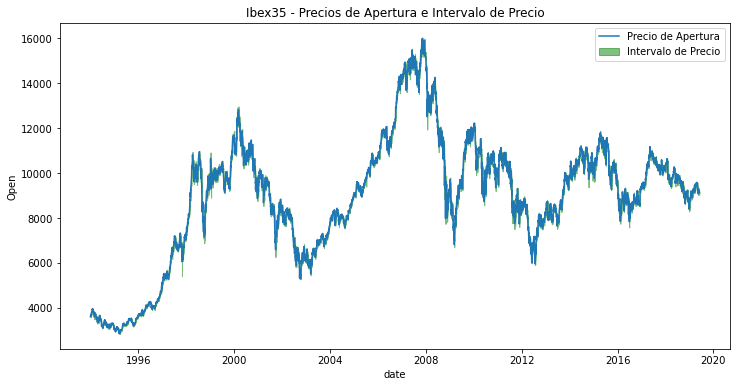

In [82]:
# serie de tiempo
fig, ax = plt.subplots(figsize=(12,6))
sns.lineplot(data=data, x="date", y="Open", label="Precio de Apertura", ax=ax)
# intervalo de alto/bajo
ax.fill_between(data.index, data.Low, data.High, alpha=0.5, label="Intervalo de Precio", color="green")
ax.legend(); ax.set_title("Ibex35 - Precios de Apertura e Intervalo de Precio")

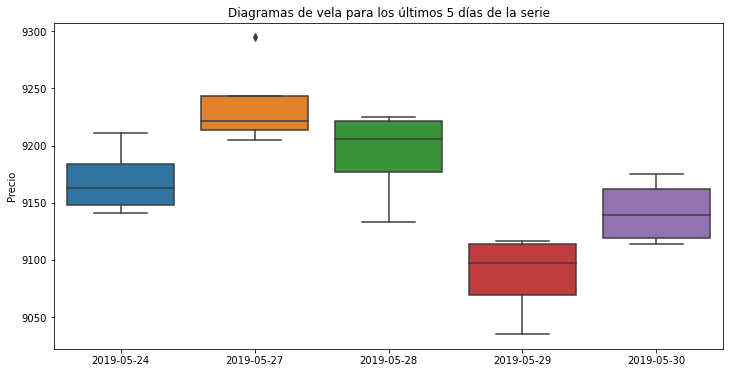

In [80]:
# diagrama de vela para dias en particular
plt.figure(figsize=(12,6))
melted = pd.melt(data.reset_index(), id_vars=["date"], value_vars=["Open", "High", "Low", "Close"])
ax = sns.boxplot(data=melted[melted.date.isin(data.index[-5:])].assign(date=lambda x: x.date.dt.strftime("%Y-%m-%d")),x="date", y="value")
ax.set(xlabel="", ylabel="Precio", title="Diagramas de vela para los últimos 5 días de la serie");

Coeficiente de correlacion: -0.173


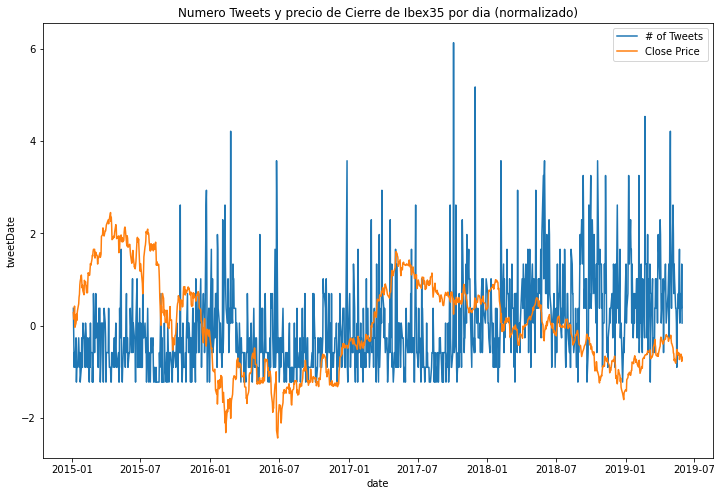

In [81]:
# se puede ver una correlacion entre el numero de tweets por dia y el precio de cierre del indice?
fig, ax = plt.subplots(figsize=(12, 8))
# tweets que se sobrelapan con las fechas de la serie de tiempo
date_intersection = data.index.intersection(tweets_df.resample("1D").count().index)
# normalizar el numero de tweets y precio de cierre para visualizarlos
tweets_by_day = tweets_df.resample("1D").count().loc[date_intersection.values].apply(lambda x: (x-x.mean())/x.std())
close_prices = data.loc[date_intersection.values,["Close"]].apply(lambda x: (x-x.mean())/x.std())
sns.lineplot(x="date",y="tweetDate",data=tweets_by_day, ax=ax, label="# of Tweets")
sns.lineplot(x="date",y="Close",data=close_prices, ax=ax, label="Close Price")
ax.set_title("Numero Tweets y precio de Cierre de Ibex35 por dia (normalizado)")
corr = np.corrcoef(tweets_by_day["tweetDate"], close_prices["Close"])[0,1]
print(f"Coeficiente de correlacion: {corr:.3f}")

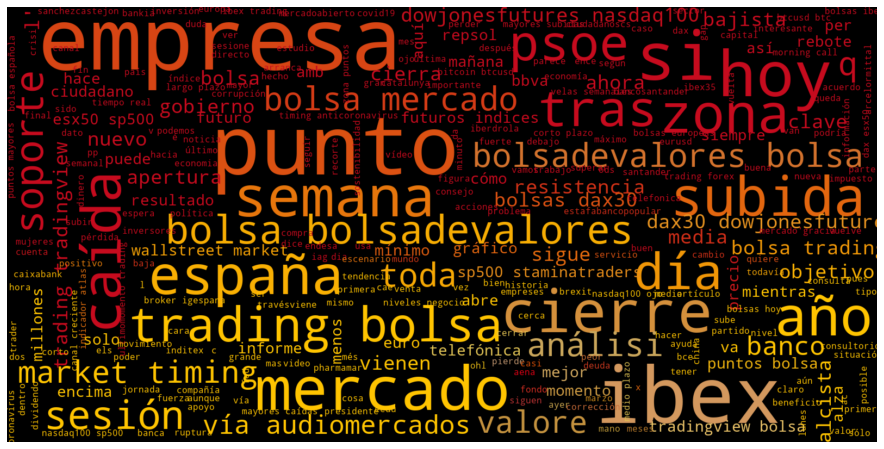

In [154]:
# que palabras suelen aparecer en los tweets?
# import nltk

from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
from io import BytesIO
import requests
import re

stopwords_esp = stopwords.words('spanish')
stopwords_esp.extend(['@', 'RT', '#'])
stopwords_eng = set(stopwords.words('english'))
STOPWORDS = STOPWORDS.union(set(stopwords_esp)).union(stopwords_eng)

img = np.array(Image.open(BytesIO(requests.get("https://stuffedeyes.files.wordpress.com/2018/06/spain-2906824_960_720.png?w=748").content)))
colors = ImageColorGenerator(img)
text = " ".join(tweets_df.text).lower().replace("#ibex35",'').replace("\n",' ').strip()
words = " ".join(w for w in text.split(" ") if 'http' not in w and "<" not in w)
worcloud = WordCloud(background_color="black", margin=0, max_words=1000, max_font_size=40, scale=4, random_state=42, stopwords=STOPWORDS).generate(words)
plt.figure(figsize=(18,8))
plt.imshow(worcloud.recolor(color_func=colors), interpolation="bilinear")
plt.axis("off");

Text(0.5, 1.0, 'Numero de Tweets por idioma')

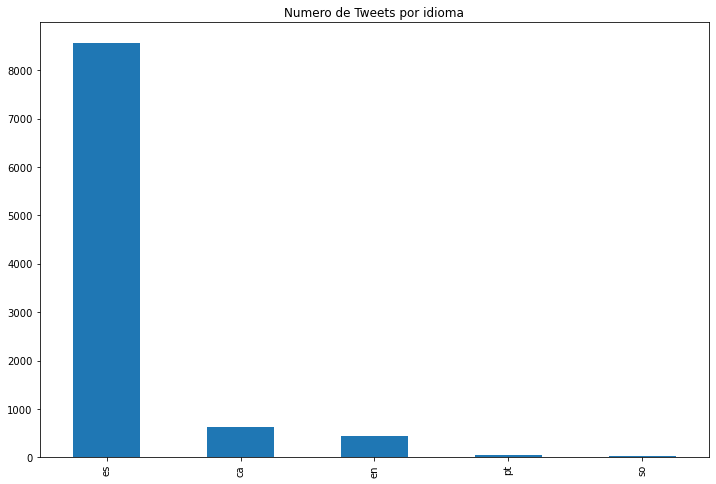

In [16]:
# en que idioma estan los tweets?
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector
import src.text_processing as text

# Add LanguageDetector and assign it a string name
@Language.factory("language_detector")
def create_language_detector(nlp, name):
    return LanguageDetector(language_detection_function=None)

mult_nlp = spacy.load('xx_sent_ud_sm')
mult_nlp.add_pipe('language_detector', last=True)

tweets_docs = text.tokenize(tweets_df.text, mult_nlp)
languages = tweets_docs.apply(lambda doc: doc._.language["language"])
fig, ax = plt.subplots(figsize=(12,8))
languages.value_counts().iloc[:5].plot(kind="bar", ax=ax)
ax.set_title("Numero de Tweets por idioma")